In [9]:
import h2o
from h2o.automl import H2OAutoML
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# initialize the H2O cluster
h2o.init()

# load the dataset into H2O
data = pd.read_csv('../data/ioperf.csv')
data['bandwidth'] /= 1000
data['total_size'] = np.log2(data['total_size'])
data['block_size'] = np.log2(data['block_size'])
data = h2o.H2OFrame(data)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,30 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_cc_fqy4uj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.96 Gb
H2O_cluster_total_cores:,48
H2O_cluster_allowed_cores:,48
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [10]:
data['total_size'] /= 1024**3
data['block_size'] /= 1024

In [11]:
# specify the target variable and the input features
y = 'latency'
X = data.columns.remove(y)

# split the dataset into training and testing subsets
train, test = data.split_frame(ratios=[0.8], seed=42)

In [12]:
# initialize the AutoML model and specify the maximum time and number of models to try
automl = H2OAutoML(max_runtime_secs=3600, max_models=10, seed=42)

# train the AutoML model
automl.train(x=X, y=y, training_frame=train)

# get the leaderboard and performance of the model
leaderboard = automl.leaderboard

# save the best model based on leaderboard rank
model_path = h2o.save_model(automl.leader, path='../models/h2o', force=True)

# get the algorithm used for the leader model
leader_algo = automl.leader.algo
print(f"Best Model: {leader_algo}")

AutoML progress: |

███████████████████████████████████████████████████████████████| (done) 100%
Best Model: xgboost


In [13]:
# print the leaderboard
print(leaderboard)

# get the performance of each model
model_ids = leaderboard['model_id'].as_data_frame()['model_id'].tolist()
for model_id in model_ids:
    model = h2o.get_model(model_id)
    performance = model.model_performance(test)
    print(model_id, performance)

model_id                                                   rmse      mse      mae       rmsle    mean_residual_deviance
XGBoost_2_AutoML_2_20230614_30022                       3.17955  10.1096  1.16348  nan                          10.1096
XGBoost_3_AutoML_2_20230614_30022                       3.23354  10.4558  1.1797   nan                          10.4558
StackedEnsemble_BestOfFamily_1_AutoML_2_20230614_30022  3.29197  10.8371  1.21558  nan                          10.8371
StackedEnsemble_AllModels_1_AutoML_2_20230614_30022     3.30712  10.937   1.16207  nan                          10.937
XGBoost_1_AutoML_2_20230614_30022                       3.37446  11.387   1.47851  nan                          11.387
GBM_2_AutoML_2_20230614_30022                           3.59307  12.9101  1.4905   nan                          12.9101
GBM_3_AutoML_2_20230614_30022                           3.59714  12.9394  1.40196  nan                          12.9394
GBM_4_AutoML_2_20230614_30022             

In [14]:
best_model = h2o.load_model(model_path)

# generate predictions on the test set
predictions = best_model.predict(test)

# evaluate the performance of the model
performance = best_model.model_performance(test)
performance

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 5.771417382164873
RMSE: 2.402377443734617
MAE: 1.086723843216896
RMSLE: NaN
Mean Residual Deviance: 5.771417382164873

/tmp/ipykernel_1998999/2073451384.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pe, hist = True, kde = True, bins=100,


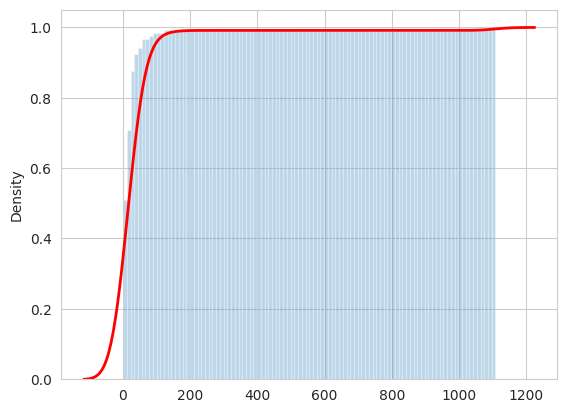

In [15]:
pe = abs((predictions - test["latency"])/test['latency']) * 100
pe = np.ravel(pe.as_data_frame().values)

sns.distplot(pe, hist = True, kde = True, bins=100,
             hist_kws={'cumulative':True,'density':True, 'alpha':0.3},
             kde_kws={'cumulative':True,'color': 'red', 'lw': 2})

sns.set_style('whitegrid')
plt.show()

In [16]:
# shutdown the H2O cluster
# h2o.shutdown()